In [5]:
print("--- STEP 1: SETUP AND PREPARATION ---")

# Connect to Google Drive - This should be the VERY FIRST step.
from google.colab import drive
drive.mount('/content/drive')

--- STEP 1: SETUP AND PREPARATION ---
Mounted at /content/drive


In [ ]:
# Install libraries
print("\n--- Installing required libraries ---")
!pip install transformers datasets evaluate accelerate scikit-learn seaborn matplotlib -q



--- Installing required libraries ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00


In [ ]:
import os
import json
import torch
import shutil # For safely copying files like config.json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)
import evaluate


In [ ]:
# Define permanent paths in Google Drive
DRIVE_BASE_PATH = '/content/drive/MyDrive/CohereProject_FrankenBERT' # Renamed for clarity
os.makedirs(DRIVE_BASE_PATH, exist_ok=True)

# Specific paths for models WITH classification heads (for final evaluation)
poet_final_save_path = os.path.join(DRIVE_BASE_PATH, 'poet_model_final')
scientist_final_save_path = os.path.join(DRIVE_BASE_PATH, 'scientist_model_final')
frankenbert_final_save_path = os.path.join(DRIVE_BASE_PATH, 'frankenbert_model_final')

# Specific paths for BASE models WITHOUT heads (for merging)
poet_base_save_path = os.path.join(DRIVE_BASE_PATH, 'poet_model_base')
scientist_base_save_path = os.path.join(DRIVE_BASE_PATH, 'scientist_model_base')

# Temporary path for heatmap models (can be in /content/ since they are transient)
temp_merge_path = '/content/temp_merge_model'


In [ ]:

# --- Hugging Face Login ---
# This allows us to potentially download gated models or push our own.
# We'll use your Colab secret named 'HF_TOKEN'.
from google.colab import userdata

try:
    hf_token = userdata.get('HF_TOKEN')
    from huggingface_hub import login
    login(token=hf_token)
    print("Successfully logged into Hugging Face Hub.")
except:
    print("Hugging Face token not found or invalid. Proceeding without login.")

Successfully logged into Hugging Face Hub.


In [ ]:
# Check for GPU
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("GPU not available. Training will be very slow.")
    device = torch.device("cpu")

GPU is available: NVIDIA A100-SXM4-40GB


In [ ]:
# Universal tokenizer and metrics
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# TRAIN SPECIALIST MODELS

## Train Model A - "The Poet" (Sentiment Expert)

In [ ]:
print("\n--- Preparing Poet (SST-2) ---")
poet_dataset = load_dataset("glue", "sst2")
def tokenize_poet(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)
tokenized_poet_dataset = poet_dataset.map(tokenize_poet, batched=True)

poet_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)
poet_training_args = TrainingArguments(output_dir="/content/poet_training_output", eval_strategy="epoch", num_train_epochs=3)
poet_trainer = Trainer(model=poet_model, args=poet_training_args, train_dataset=tokenized_poet_dataset["train"], eval_dataset=tokenized_poet_dataset["validation"], compute_metrics=compute_metrics)

print("--- Starting Poet training ---")
poet_trainer.train()
poet_trainer.save_model(poet_final_save_path)
print(f"--- Poet training complete. Final model saved to: {poet_final_save_path} ---")


--- Preparing Poet (SST-2) ---


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Starting Poet training ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vinodanbalagan (vinodanbalagan-university-of-toronto) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.231400,0.403396,0.894495
2,0.149800,0.480491,0.899083
3,0.086500,0.462373,0.902523


--- Poet training complete. Final model saved to: /content/drive/MyDrive/CohereProject_FrankenBERT/poet_model_final ---


## Train Model B - "The Scientist" (Factual Expert)

In [ ]:
print("\n--- Preparing Scientist (AG News) ---")
scientist_dataset = load_dataset("ag_news")
def tokenize_scientist(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)
tokenized_scientist_dataset = scientist_dataset.map(tokenize_scientist, batched=True).rename_column("label", "labels")

scientist_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4)
scientist_training_args = TrainingArguments(output_dir="/content/scientist_training_output", eval_strategy="epoch", num_train_epochs=3)
scientist_trainer = Trainer(model=scientist_model, args=scientist_training_args, train_dataset=tokenized_scientist_dataset["train"], eval_dataset=tokenized_scientist_dataset["test"], compute_metrics=compute_metrics)



--- Preparing Scientist (AG News) ---


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print("--- Starting Scientist training ---")
scientist_trainer.train()
scientist_trainer.save_model(scientist_final_save_path)
print(f"--- Scientist training complete. Final model saved to: {scientist_final_save_path} ---")

--- Starting Scientist training ---


Epoch,Training Loss,Validation Loss,Accuracy
1,0.247300,0.235374,0.935526
2,0.162500,0.239797,0.945658
3,0.109900,0.254616,0.945658


--- Scientist training complete. Final model saved to: /content/drive/MyDrive/CohereProject_FrankenBERT/scientist_model_final ---


## DECAPITATE AND MERGE MODELS

In [ ]:
print("\n\n--- STEP 3: DECAPITATE AND MERGE MODELS ---")

# --- Decapitate and save BASE models to Google Drive ---
print("--- Decapitating models (removing classification heads) ---")
poet_base_model = AutoModel.from_pretrained(poet_final_save_path)
poet_base_model.save_pretrained(poet_base_save_path)
print(f"-> Poet base model saved to: {poet_base_save_path}")

scientist_base_model = AutoModel.from_pretrained(scientist_final_save_path)
scientist_base_model.save_pretrained(scientist_base_save_path)
print(f"-> Scientist base model saved to: {scientist_base_save_path}")

# --- Manual PyTorch Merge ---
print("\n--- Performing manual merge with PyTorch ---")
model_a = AutoModel.from_pretrained(poet_base_save_path)
model_b = AutoModel.from_pretrained(scientist_base_save_path)
params_a = model_a.state_dict()
params_b = model_b.state_dict()
merged_params = OrderedDict()

print("Averaging tensors for 50/50 merge...")
for key in params_a.keys():
    merged_params[key] = (params_a[key] + params_b[key]) / 2.0

template_model = AutoModel.from_pretrained(model_checkpoint)
template_model.load_state_dict(merged_params)
template_model.save_pretrained(frankenbert_final_save_path)
tokenizer.save_pretrained(frankenbert_final_save_path)
print(f"--- MANUAL MERGE COMPLETE! FrankenBERT saved to: {frankenbert_final_save_path} ---")



--- STEP 3: DECAPITATE AND MERGE MODELS ---
--- Decapitating models (removing classification heads) ---
-> Poet base model saved to: /content/drive/MyDrive/CohereProject_FrankenBERT/poet_model_base
-> Scientist base model saved to: /content/drive/MyDrive/CohereProject_FrankenBERT/scientist_model_base

--- Performing manual merge with PyTorch ---
Averaging tensors for 50/50 merge...
--- MANUAL MERGE COMPLETE! FrankenBERT saved to: /content/drive/MyDrive/CohereProject_FrankenBERT/frankenbert_model_final ---


## The Grand Evaluation

In [ ]:
print("\n\n--- STEP 4: EVALUATION ---")

def evaluate_model_on_task(model_path, dataset_name):
    print(f"\n--- Evaluating {os.path.basename(model_path)} on {dataset_name} ---")
    if dataset_name == "sst2":
        dataset = load_dataset("glue", "sst2", split="validation")
        tokenized_dataset = dataset.map(tokenize_poet, batched=True)
        num_labels = 2
    elif dataset_name == "ag_news":
        dataset = load_dataset("ag_news", split="test")
        tokenized_dataset = dataset.map(tokenize_scientist, batched=True).rename_column("label", "labels")
        num_labels = 4
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels, ignore_mismatched_sizes=True)
    eval_args = TrainingArguments(output_dir="/content/eval_temp", per_device_eval_batch_size=64, report_to="none")
    eval_trainer = Trainer(model=model, args=eval_args, compute_metrics=compute_metrics)
    results = eval_trainer.evaluate(eval_dataset=tokenized_dataset)
    return results['eval_accuracy']

results = {}
models_to_test = {
    "poet_model": poet_final_save_path,
    "scientist_model": scientist_final_save_path,
    "frankenbert_model": frankenbert_final_save_path
}

for model_name, model_path in models_to_test.items():
    results[model_name] = {}
    for dataset_name in ["sst2", "ag_news"]:
        accuracy = evaluate_model_on_task(model_path, dataset_name)
        results[model_name][dataset_name] = accuracy
        print(f"-> Accuracy for {model_name} on {dataset_name}: {accuracy:.4f}")

results_df = pd.DataFrame(results).T
results_df.columns = ["Sentiment Accuracy (SST-2)", "News Accuracy (AG News)"]
print("\n\n--- FINAL RESULTS ---")
print(results_df)



--- STEP 4: EVALUATION ---

--- Evaluating poet_model_final on sst2 ---


-> Accuracy for poet_model on sst2: 0.9025

--- Evaluating poet_model_final on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CohereProject_FrankenBERT/poet_model_final and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> Accuracy for poet_model on ag_news: 0.3267

--- Evaluating scientist_model_final on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CohereProject_FrankenBERT/scientist_model_final and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> Accuracy for scientist_model on sst2: 0.4931

--- Evaluating scientist_model_final on ag_news ---


-> Accuracy for scientist_model on ag_news: 0.9457

--- Evaluating frankenbert_model_final on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CohereProject_FrankenBERT/frankenbert_model_final and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> Accuracy for frankenbert_model on sst2: 0.5356

--- Evaluating frankenbert_model_final on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CohereProject_FrankenBERT/frankenbert_model_final and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-> Accuracy for frankenbert_model on ag_news: 0.1221


--- FINAL RESULTS ---
                   Sentiment Accuracy (SST-2)  News Accuracy (AG News)
poet_model                           0.902523                 0.326711
scientist_model                      0.493119                 0.945658
frankenbert_model                    0.535550                 0.122105


## Visualizations



--- STEP 5: VISUALIZATION AND EVIDENCE ---

--- Loading final models into memory for live predictions ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/CohereProject_FrankenBERT/frankenbert_model_final and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Generating Bar Chart ---


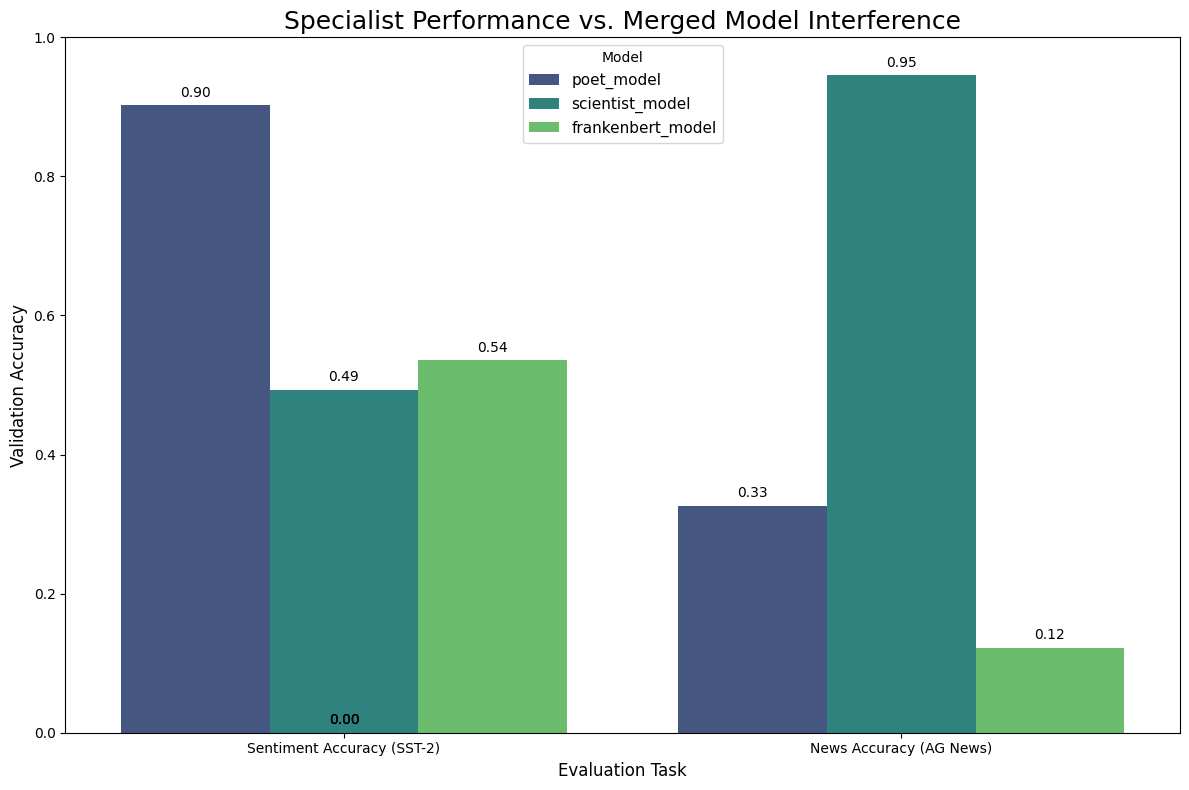


--- Generating Heatmap ---
--- Evaluating merge ratio: 0.0 ---

--- Evaluating temp_merge_model on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating temp_merge_model on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Evaluating merge ratio: 0.25 ---

--- Evaluating temp_merge_model on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating temp_merge_model on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Evaluating merge ratio: 0.5 ---

--- Evaluating temp_merge_model on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating temp_merge_model on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Evaluating merge ratio: 0.75 ---

--- Evaluating temp_merge_model on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating temp_merge_model on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--- Evaluating merge ratio: 1.0 ---

--- Evaluating temp_merge_model on sst2 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Evaluating temp_merge_model on ag_news ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/temp_merge_model and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


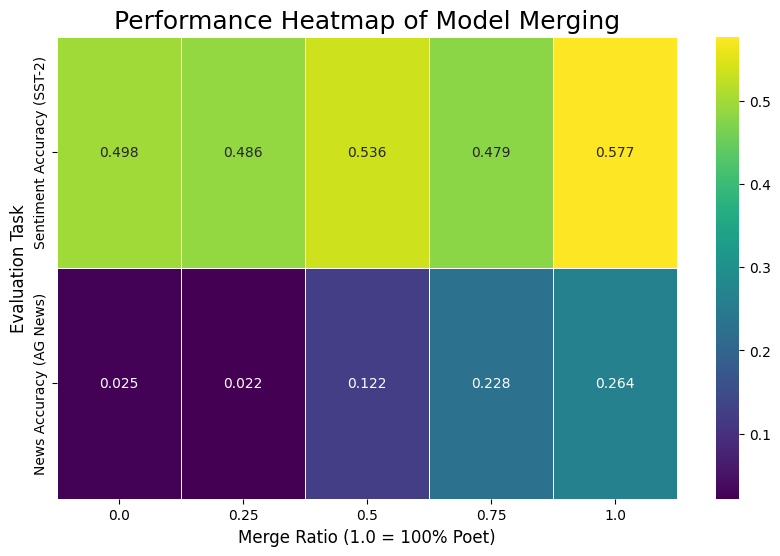


--- Heatmap Results ---
            Sentiment Accuracy (SST-2)  News Accuracy (AG News)
Poet Ratio                                                     
0.00                          0.497706                 0.025000
0.25                          0.486239                 0.021842
0.50                          0.535550                 0.122105
0.75                          0.479358                 0.228289
1.00                          0.576835                 0.264079


In [ ]:
print("\n\n--- STEP 5: VISUALIZATION AND EVIDENCE ---")
import seaborn as sns

# --- Load final models for live prediction ---
print("\n--- Loading final models into memory for live predictions ---")
# Make sure to move models to the GPU if you have one
poet_model = AutoModelForSequenceClassification.from_pretrained(poet_final_save_path).to(device)
scientist_model = AutoModelForSequenceClassification.from_pretrained(scientist_final_save_path).to(device)
frankenbert_model = AutoModelForSequenceClassification.from_pretrained(frankenbert_final_save_path).to(device)


# --- The Grouped Bar Chart ---
print("\n--- Generating Bar Chart ---")
results_for_plot = results_df.reset_index().melt(id_vars='index', var_name='Task', value_name='Accuracy')
results_for_plot.rename(columns={'index': 'Model'}, inplace=True)
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=results_for_plot, x='Task', y='Accuracy', hue='Model', palette='viridis')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.title('Specialist Performance vs. Merged Model Interference', fontsize=18)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Evaluation Task', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Model', fontsize=11)
plt.tight_layout()
plt.show()

# --- The Interference Heatmap ---
print("\n--- Generating Heatmap ---")
heatmap_data = []
merge_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]
for ratio in merge_ratios:
    print(f"--- Evaluating merge ratio: {ratio} ---")
    merged_params = OrderedDict()
    for key in params_a.keys():
        merged_params[key] = (params_a[key] * ratio) + (params_b[key] * (1.0 - ratio))
    template_model.load_state_dict(merged_params)
    template_model.save_pretrained(temp_merge_path)
    tokenizer.save_pretrained(temp_merge_path)
    acc_sst2 = evaluate_model_on_task(temp_merge_path, "sst2")
    acc_ag_news = evaluate_model_on_task(temp_merge_path, "ag_news")
    heatmap_data.append({"Poet Ratio": ratio, "Sentiment Accuracy (SST-2)": acc_sst2, "News Accuracy (AG News)": acc_ag_news})

heatmap_df = pd.DataFrame(heatmap_data).set_index("Poet Ratio")
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.T, annot=True, fmt=".3f", cmap="viridis", linewidths=.5)
plt.title('Performance Heatmap of Model Merging', fontsize=18)
plt.ylabel('Evaluation Task', fontsize=12)
plt.xlabel('Merge Ratio (1.0 = 100% Poet)', fontsize=12)
plt.show()
print("\n--- Heatmap Results ---")
print(heatmap_df)



## Prediction Evidence

In [ ]:
print("\n\n--- FINAL EVIDENCE: LIVE PREDICTIONS ---")
def get_prediction(model, tokenizer, text, label_map):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = F.softmax(logits, dim=1)
    confidence, predicted_class_idx = torch.max(probabilities, dim=1)
    predicted_label = label_map[predicted_class_idx.item()]
    confidence_score = confidence.item()
    return predicted_label, confidence_score

sst2_label_map = {0: 'NEGATIVE', 1: 'POSITIVE'}
ag_news_label_map = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
sentiment_sentence = "The film was a masterpiece of emotional storytelling."
news_sentence = "The central bank announced a new policy to curb inflation."

print("="*50)
print(f"TASK 1: SENTIMENT ANALYSIS\nInput: '{sentiment_sentence}'")
print("="*50)
label, score = get_prediction(poet_model, tokenizer, sentiment_sentence, sst2_label_map)
print(f"Poet Model Prediction:     {label} (Confidence: {score:.2%})")
label, score = get_prediction(scientist_model, tokenizer, sentiment_sentence, sst2_label_map)
print(f"Scientist Model Prediction:  {label} (Confidence: {score:.2%})")
label, score = get_prediction(frankenbert_model, tokenizer, sentiment_sentence, sst2_label_map)
print(f"FrankenBERT Model Prediction: {label} (Confidence: {score:.2%})")

print("\n" + "="*50)
print(f"TASK 2: NEWS CLASSIFICATION\nInput: '{news_sentence}'")
print("="*50)
label, score = get_prediction(poet_model, tokenizer, news_sentence, ag_news_label_map)
print(f"Poet Model Prediction:     {label} (Confidence: {score:.2%})")
label, score = get_prediction(scientist_model, tokenizer, news_sentence, ag_news_label_map)
print(f"Scientist Model Prediction:  {label} (Confidence: {score:.2%})")
label, score = get_prediction(frankenbert_model, tokenizer, news_sentence, ag_news_label_map)
print(f"FrankenBERT Model Prediction: {label} (Confidence: {score:.2%})")



--- FINAL EVIDENCE: LIVE PREDICTIONS ---
TASK 1: SENTIMENT ANALYSIS
Input: 'The film was a masterpiece of emotional storytelling.'
Poet Model Prediction:     POSITIVE (Confidence: 99.99%)
Scientist Model Prediction:  NEGATIVE (Confidence: 99.58%)
FrankenBERT Model Prediction: NEGATIVE (Confidence: 55.57%)

TASK 2: NEWS CLASSIFICATION
Input: 'The central bank announced a new policy to curb inflation.'
Poet Model Prediction:     Sports (Confidence: 93.97%)
Scientist Model Prediction:  Business (Confidence: 98.25%)
FrankenBERT Model Prediction: World (Confidence: 52.59%)


In [9]:
import json
from google.colab import drive

# Define the path to your notebook in Google Drive
notebook_path = '/content/drive/MyDrive/Colab_Notebooks/FrankenBERT.ipynb' # Replace with your notebook path

# Mount Google Drive if not already mounted
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted.")

# Load the notebook file
with open(notebook_path, 'r') as f:
    notebook_content = json.load(f)

# Remove the 'outputs' and 'execution_count' from code cells
# and 'metadata' from the notebook
for cell in notebook_content['cells']:
    if cell['cell_type'] == 'code':
        cell['outputs'] = []
        cell['execution_count'] = None
    if 'metadata' in cell:
        if 'widgets' in cell['metadata']:
            del cell['metadata']['widgets']

if 'metadata' in notebook_content:
    if 'widgets' in notebook_content['metadata']:
        del notebook_content['metadata']['widgets']


# Define a new path to save the cleaned notebook
cleaned_notebook_path = '/content/FrankenBERT_cleaned.ipynb' # Saves to the local Colab environment

# Save the modified notebook
with open(cleaned_notebook_path, 'w') as f:
    json.dump(notebook_content, f, indent=2)

print(f"\nWidget state removed. Cleaned notebook saved to: {cleaned_notebook_path}")
print("You can now download this file from the Colab file explorer (the folder icon on the left sidebar).")

Mounted at /content/drive
Google Drive mounted successfully.

Widget state removed. Cleaned notebook saved to: /content/FrankenBERT_cleaned.ipynb
You can now download this file from the Colab file explorer (the folder icon on the left sidebar).
